## Необходимые программы: Anaconda Prompt
Откройте Anaconda Prompt и выполните следующию команду (команду также можно выполнить из ячейки Jupyter)
pip install psycopg2
(для MacOS):
pip install psycopg2-binary

# ДЗ 2

In [1]:
# Создаем соединение c базой данных -
import psycopg2 # драйвер для postgresql
import getpass  # прячем пароль, чтобы не писать его в параметрах
import pandas as pd
import datetime

#Обратите внимание на параметр database=... имя базы данных должно совпадать с названием Вашей БД. У меня она по умолчанию назвалась
# postgres, но в кодах с семинаров мы использовали test
conn=psycopg2.connect(user='postgres',
                      database='postgres',
                      host='localhost',
                      port='5432',
                      password=getpass.getpass('Insert password: ')
                        )
print(conn.get_dsn_parameters())

Insert password: ········
{'user': 'postgres', 'dbname': 'postgres', 'host': 'localhost', 'port': '5432', 'tty': '', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'}


In [2]:
# Достаем данные из БД
# Замечание касательно отбора максимального купона - в таблице Quotes по некоторым облигациям есть данные по различным купонным
# выплатам, при этом в bond_ description эти облигации имеют тип купона - постоянный.
# Также мы сразу фильтруем вытягиваемые данные, отсеивая те, которые имеют статус "Погашен", что бы потом не повторять это в функции

query = """ SELECT *
            FROM (SELECT MAX("CPN") AS "CPN", "ISIN", max("BUYBACKDATE") AS "BUYBACKDATE",
                  max("BUYBACKPRICE") AS "BUYBACKPRICE"
                  FROM public.quotes_task  
                  GROUP BY "ISIN") AS cpn
            INNER JOIN(SELECT "ISINCode", "FaceValue", "HaveOffer", "AmortisedMty", 
                       "CouponPerYear", "NumCoupons", "EndMtyDate", "CouponType", "IssuerName"
            FROM public.bond_description_task 
                       WHERE "Status"!='Погашен') AS bonds
            ON cpn."ISIN" = bonds."ISINCode" """

# Загружаем в python

data = pd.read_sql_query(query, conn)
data = pd.DataFrame(data)
data.head(5)

,CPN,ISIN,BUYBACKDATE,BUYBACKPRICE,ISINCode,FaceValue,HaveOffer,AmortisedMty,CouponPerYear,NumCoupons,EndMtyDate,CouponType,IssuerName
0,NaN,RU000A0E5690,None,0.0,RU000A0E5690,1000.0,True,False,4,16,2009-06-09,Переменный,Нутринвестхолдинг
1,41.1400,RU000A0GN9B5,2013-02-21,100.0,RU000A0GN9B5,1000.0,True,False,2,20,2016-02-18,Переменный,Мосэнерго (ТГК-3)
2,30.2918,RU000A0JNGU3,2016-01-06,100.0,RU000A0JNGU3,1000.0,True,False,4,40,2016-07-06,Переменный,Банк ВТБ
3,NaN,RU000A0JNN80,None,0.0,RU000A0JNN80,1000.0,False,False,2,6,2009-09-17,Постоянный,МГ Групп
4,40.1100,RU000A0JNYN1,None,NaN,RU000A0JNYN1,1000.0,False,False,2,31,2022-06-11,Фиксированный,Москва Правительство


In [3]:
# Поле ISINCode было нужно нам для джойна, сейчас его можно выбросить
data = data.drop(['ISINCode'], axis=1)
data.head(5)

,CPN,ISIN,BUYBACKDATE,BUYBACKPRICE,FaceValue,HaveOffer,AmortisedMty,CouponPerYear,NumCoupons,EndMtyDate,CouponType,IssuerName
0,NaN,RU000A0E5690,None,0.0,1000.0,True,False,4,16,2009-06-09,Переменный,Нутринвестхолдинг
1,41.1400,RU000A0GN9B5,2013-02-21,100.0,1000.0,True,False,2,20,2016-02-18,Переменный,Мосэнерго (ТГК-3)
2,30.2918,RU000A0JNGU3,2016-01-06,100.0,1000.0,True,False,4,40,2016-07-06,Переменный,Банк ВТБ
3,NaN,RU000A0JNN80,None,0.0,1000.0,False,False,2,6,2009-09-17,Постоянный,МГ Групп
4,40.1100,RU000A0JNYN1,None,NaN,1000.0,False,False,2,31,2022-06-11,Фиксированный,Москва Правительство


In [4]:
# Объявляем процедуру, которая будет переводить дату, введенную пользователем, из строкового формата в дату

def get_date(date_entry):
    year, month, day = map(int, date_entry.split('-'))
    return datetime.date(year, month, day)

In [5]:
# Для начала общий концепт: по каждой облигации у нас есть информация по ее Maturity date, а также периодичность выплаты купонов
# и их общее число. Тогда все даты платежей можно задать путем отнимания от EndMtyDate числа дней, соответствующих периодичности
# выплаты купона. И так повторить N раз - число NumCoupons. Это будет полная матрица платежей по одной облигации. Однако нас
# интересует ее усеченная версия, где точкой отсечения является введенная пользователем дата

def my_fun(issuer_name, terminal_date):
    # составим список дат платежей для каждой облигации
    
    # получим нужные облигации
    terminal_date = get_date(terminal_date)
    obligations = data[data['IssuerName'] == issuer_name]
    
    
    matrix = dict()
    
    # для каждой облигации формируем список дат платежей
    for index, obligation in obligations.iterrows():
        matrix[obligation['ISIN']] = []
        
        # сначала определяем интервалы, через которые будут отсекаться даты относительно последнего платежа
        period = 365 // obligation['CouponPerYear']
        
        # определяем дату последнего платежа (с учетом условия про наличие оферты)
        payment_date = None
        if obligation['BUYBACKDATE'] is not None:
            payment_date = obligation['BUYBACKDATE']
        else:
            payment_date = obligation['EndMtyDate']
        
        # Основной цикл, который, вроде бы, реализует "концепт", изложенный выше - "нарезка" дат
        for i in range(obligation['NumCoupons']):
            
            # даты больше введеной пропускаем
            if payment_date > terminal_date:
                pass
            else:
                matrix[obligation['ISIN']].append(payment_date)
            
            # считаем следующую дату выплаты
            payment_date = payment_date - datetime.timedelta(days=period)
    return matrix    

In [6]:
# Теперь необходимо сформировать подобие сводной таблицы, где строками будут ИСИНы облигаций, а столбцами - даты платежей
def build_pivot(matrix_dict):
    
    # сначала получим список всех дат всех облигаций и упорядочим по возрастанию
    date_set=set()
    for isin in matrix_dict:
        date_set.update(matrix_dict[isin])
    date_set = list(date_set)
    date_set.sort()
    
    # создаем сводную таблицу
    rs = pd.Index(matrix_dict.keys(), name='ISIN')
    cs = pd.Index(date_set, name="dates_payments")
    df = pd.DataFrame(data = '0', index = rs, columns = cs)
    
    # заполняем дата фрейм
    for isin in matrix_dict:
        
        # для каждой облигации берем список дат
        datelist = matrix_dict[isin]
        
        # и заполняем его верным значением в зависимости от даты
        obligation = data[data['ISIN'] == isin].iloc[0]
        cpn = obligation['CPN']
        face_value = obligation['FaceValue']
        
        # определяем верную дату
        terminal_date = None
        if obligation['BUYBACKDATE'] is not None:
            terminal_date = obligation['BUYBACKDATE']
        else:
            terminal_date = obligation['EndMtyDate']
            
        for the_date in datelist:
        # и наконец заполняем значение выплаты
            if the_date == terminal_date:
                df.at[isin, the_date] = cpn + face_value
            else:
                df.at[isin, the_date] = cpn
    return df

In [8]:
issuer_name = input('Введите IssuerName')
term_date = input('Введите дату в формате YYYY-MM-DD')
matrix_dict = my_fun(issuer_name, term_date)
var = build_pivot(matrix_dict).head(15)
var

Введите IssuerNameБанк ВТБ
Введите дату в формате YYYY-MM-DD2007-06-06


dates_payments,2006-04-07,2006-04-19,2006-07-07,2006-07-19,2006-10-06,2006-10-18,2006-10-20,2007-01-05,2007-01-17,2007-01-19,2007-04-06,2007-04-18,2007-04-20
ISIN,,,,,,,,,,,,,
RU000A0JNGU3,0,30.2918,0,30.2918,0,30.2918,0,0,30.2918,0,0,30.2918,0
RU000A0JTK20,0,0,0,0,0,0,0,0,0,0,0,0,0
RU000A0JTN01,0,0,0,0,0,0,0,0,0,0,0,0,0
RU000A0JU773,0,0,0,0,0,0,35.28,0,0,35.28,0,0,35.28
RU000A0JUQE1,0,0,0,0,0,0,0,0,0,0,0,0,0
RU000A0JV3Q3,42.3836,0,42.3836,0,42.3836,0,0,42.3836,0,0,42.3836,0,0


# 4 ДЗ 

In [9]:
# 4 ДЗ - таблица для сохранения - будем сохранять таблицу, полученную по итогам ДЗ 2
table_name = input ('Придумайте название для сохраняемой таблицы: ')
c = len(table_name)

# проверка на пустую строку
if c == 0:
    table_name = 'Таблица платежей по облигациям эмитента ' + str(issuer_name)
else:
    table_name = table_name
    
table_path = input ('Укажите путь для сохранения таблицы: ')
p = len(table_path)
if p == 0:
    table_path = 'C:\\Users\\Public'
else:
    table_path = table_path
    
var.to_csv(table_path + '\\' + table_name + '.csv', index = True)

Придумайте название для сохраняемой таблицы: табл
Укажите путь для сохранения таблицы: 


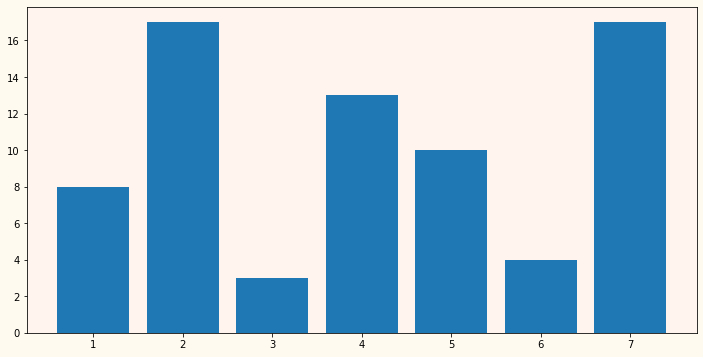

Придумайте название для рисунка: рисунок22
Укажите путь для сохранения графика: 


<Figure size 432x288 with 0 Axes>

In [12]:
# 4 ДЗ - создадим рандомный график (гистограмму), т.к. ДЗ 3 пока не готово
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np
# x = var.columns
# y = var.iloc[0]
# fig, ax = plt.subplots()
# ax.bar(x, y)

# ax.set_facecolor('seashell')
# fig.set_facecolor('floralwhite')

x = np.arange(1, 8)
y = np.random.randint(1, 20, size = 7)

fig, ax = plt.subplots()

ax.bar(x, y)

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure

plt.show()
# plt.savefig('xxx.png')

# Сохранение рисунка
pic_name = input ('Придумайте название для рисунка: ')
pic = len(pic_name)

# проверка на пустую строку
if pic == 0:
    pic_name = 'График денежных потоков по одной из облигаций эмитента ' + str(issuer_name)
else:
    pic_name = pic_name
    
pic_path = input ('Укажите путь для сохранения графика: ')
way = len(pic_path)
if way == 0:
    pic_path = 'C:\\Users\\Public'
else:
    pic_path = pic_path
    
plt.savefig(pic_path + '\\' + pic_name + '.png')

In [ ]:
# ДЗ 4 - для начала необходимо подключить некоторые библиотеки, инструкцию можно найти здесь: 
# https://github.com/IT4finance/seminars/blob/master/seminar_13_dec_report_update.ipynb


# Собираем автоматический отчет в виде pdf

from __future__ import print_function
from jinja2 import Environment, FileSystemLoader
from weasyprint import HTML, Document
import os

env = Environment(loader=FileSystemLoader('.'))
template = env.get_template("myreport.html") # Шаблон отчета должен находиться в рабочей директории
template_vars = {"title": "Отчет составлен Мельником Антоном Вячеславовичем",
                "INTRO": "Отчет о денежных потоках по облигациям эмитента " + str(issuer_name),
                 "TABLE_DESC": "Таблица денежных потоков по облигациям эмитента " +str(issuer_name) + "на дату" + str(terminal_date), 
                 "TABLE": var.to_html(), 
                 "IMAGE_DESC": "На графике изображены денежные потоки по одной из облагий эмитента " + str(issuer_name), 
                 "IMAGE": os.path.realpath(pic_path + '\\' + pic_name + '.png')
                }
# os.path.realpath - путь к файлу относительно рабочей папки. Код выше подразумевает, что картинка хранится в рабочей папке.
# Собираем и печатаем репорт
html_out = template.render(template_vars, presentational_hints=True)
HTML(string=html_out).write_pdf('my_report.pdf', presentational_hints=True)